# Sort spikes and make bout/motif rasters
Bird z_w12m7_20
For a single sglx run folder (for now):
 - Load the wav_mic file
 - pick a template of the motif (load from wav or from a set of boundaries within the same file)
 - run a template matching
 - plot all the candidates
 - manually enter a list of the ones that are a match
 - save that list
 
 TODO:
  - Pre-process with TS's denoising algorithm
  - Make a more user friendly GUI-like tool to curate the candidate motifs
  - Run a less dumb, first-grader approach to the template matching

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

### requires methods from a github repository to compute spectrograms and correlations
https://github.com/zekearneodo/ceciestunepipe

It only uses the /util/sound modules, which require the rosa package

In [2]:
from ceciestunepipe.util.sound import spectral as sp
logger.info('all modules loaded')

2021-11-22 17:05:19,738 root         INFO     all modules loaded


# Select folder where the wav_mic.wav file lives

#### Session parameters and raw files
#### Skip this part if you want to use the wav file path instead

In [3]:
# I only use this one to get the file locations easily
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu

In [241]:
bird = 'z_r12r13_21'

sess_par = {'bird': 'z_r12r13_21',
           'sess': '2021-07-01',
           'probe': 'probe_0',
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-11-29 17:46:02,359 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21', 'raw': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-07-01', 'sglx': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-07-01/sglx', 'kwik': '/scratch/earneodo/z_r12r13_21/sglx/kwik/2021-07-01', 'processed': '/mnt/sphere/speech_bci/processed_data/z_r12r13_21/2021-07-01/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-07-01/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/z_r12r13_21/sglx/msort/2021-07-01', 'ksort': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-07-01/2', 'sort': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-07-01/sglx/2'}, 'files': {'par': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-07-01/2/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-07-01/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-07-01/sglx/rig.json', 'kwd': '/scratch/ear

['0724_g0', '1229_g0']

In [263]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[1] # dir_g0 is the one that has bouts of song
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [264]:
derived_folder = exp_struct['folders']['derived']
derived_folder

'/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-07-01/sglx/1229_g0'

## Or enter the folder by hand

In [265]:
# derived_folder = '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0'
mic_file_path = os.path.join(derived_folder, 'wav_mic.wav')

## Find motifs with template matching
- The mic stream comes from the mic, saved in sglx_pre-process
- A template is marked in that file
- A template matching runs over the whole file
- Manual curation selects the candidates

In [266]:
mic_file_path

'/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-07-01/sglx/1229_g0/wav_mic.wav'

In [267]:
from ceciestunepipe.util.sound import spectral as sp

In [271]:
mic_s_f, mic_stream = wavfile.read(mic_file_path)
mic_stream = mic_stream[:, 0]

In [272]:
mic_stream.shape

(154840013,)

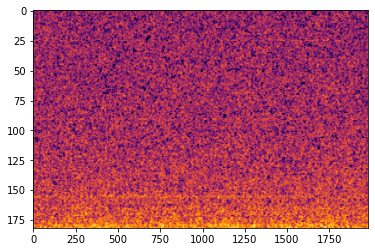

In [273]:
f, t, s = sp.ms_spectrogram(mic_stream[300000:350000], mic_s_f)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [274]:
mic_s_f

25000

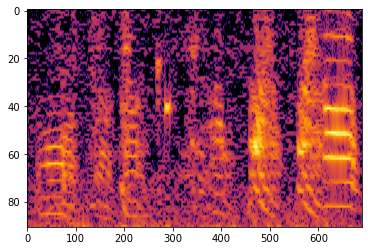

In [96]:
temp_start_s = 4938.8
temp_len_s = 0.7

n_window = 256
temp_start_sample = int(temp_start_s * mic_s_f)
temp_end_sample = temp_start_sample + int(mic_s_f * temp_len_s)

template = mic_stream[temp_start_sample: temp_end_sample]

f, t, s = sp.ms_spectrogram(template, mic_s_f, n_window)

#plt.plot(template)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [149]:
### save the template
temp_wav_name = 'mot_template.wav'

temp_wav_path = os.path.join(exp_struct['folders']['derived'], temp_wav_name)

logger.info('saving template to {}'.format(temp_wav_path))
wavfile.write(temp_wav_path, mic_s_f, template)

2021-11-24 17:31:13,305 root         INFO     saving template to /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-29/sglx/1842_g0/mot_template.wav


In [252]:
s_f_khz = int(round(mic_s_f * 0.001)) * 1000

def spectral_diff(u, v):
    spec_diff = u / np.linalg.norm(u) - v / np.linalg.norm(v)
    return np.linalg.norm(spec_diff) / np.sqrt(spec_diff.size)

In [275]:
def match_template(x, template, s_f, f_min=300, f_max=7000, n_window=256, threshold=None):
    # get the spectrogram of all of the signal
    # get the differences along the time axis
    # find peaks
    # if threshold is none, compute a reference that is the self-similarity of the pattern when shifted 20 ms
    
    # compute the difference between the template and the spectrogram
    
    # very inefficient (and memory consuming)
    logger.info('Getting spectrogram of the whole mic channel')
    
    f, t_all, s_all = sp.ms_spectrogram(x, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    f, t_temp, s_temp = sp.ms_spectrogram(template, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    if threshold is None:
        logger.info('no threhold was entered, will set it from self-similarity of pattern shifted 20ms')
        threshold = spectral_diff(s_temp[:,20:], s_temp[:,:-20])
        logger.info('threshold is {}'.format(threshold))
    
    n_s = s_temp.shape[1]
    n_a = s_all.shape[1]
    
    logger.info('getting spectral differences')
    dist_t = np.array([spectral_diff(s_temp, 
                                     s_all[:, i: i + n_s]) for i in range(n_a - n_s)])
    
    # make positive to find peaks
    inv_dist_t = 1 - dist_t
    inv_thresh = 1 - threshold
    
    peaks = signal.find_peaks(inv_dist_t, height=inv_thresh, distance=int(n_s*0.7))
    
    logger.info('Found {} candidates'.format(peaks[0].size))
    
    return peaks, s_temp, s_all, dist_t


p, s_temp, s_all, dist_t = match_template(mic_stream.flatten(), template, s_f_khz)

2021-12-01 11:38:15,789 root         INFO     Getting spectrogram of the whole mic channel
2021-12-01 11:40:05,885 root         INFO     no threhold was entered, will set it from self-similarity of pattern shifted 20ms
2021-12-01 11:40:05,887 root         INFO     threshold is 0.005333984668473593
2021-12-01 11:40:05,888 root         INFO     getting spectral differences
2021-12-01 12:04:07,379 root         INFO     Found 14 candidates


2021-12-01 12:13:45,223 root         INFO     plotting candidates


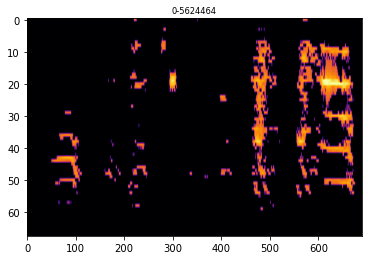

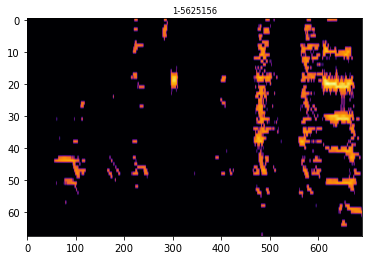

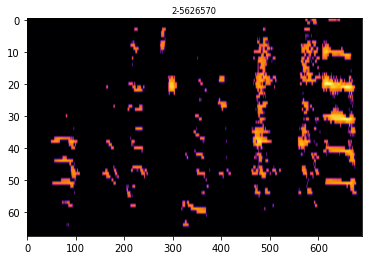

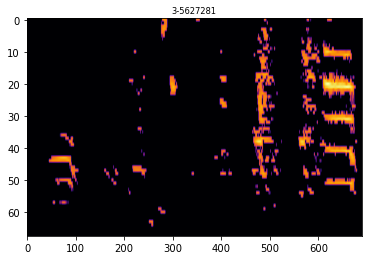

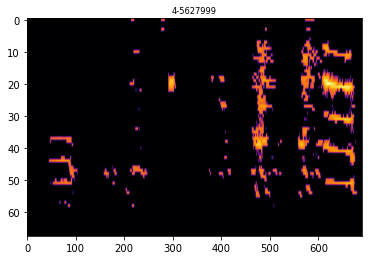

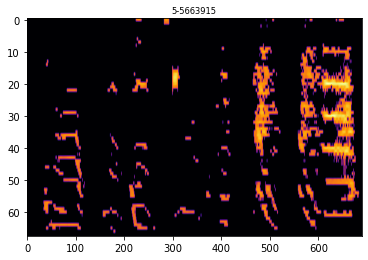

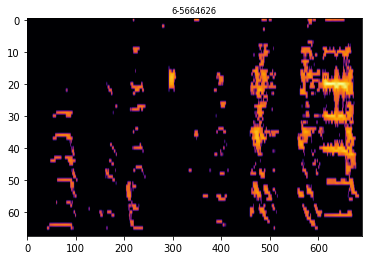

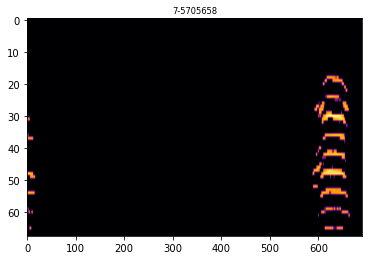

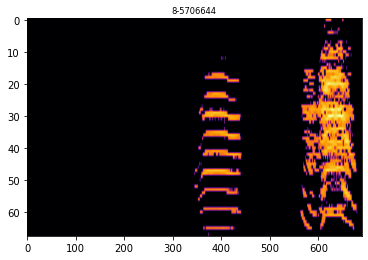

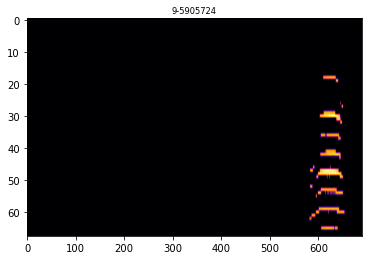

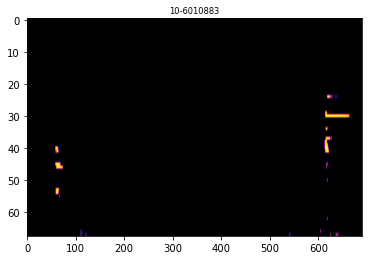

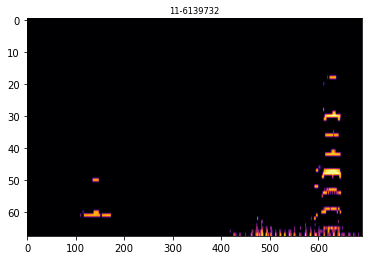

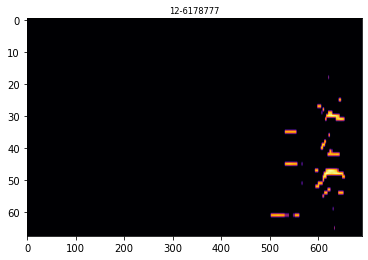

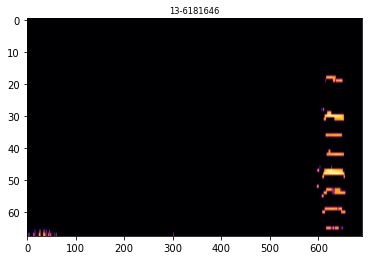

In [277]:
logger.info('plotting candidates')
for i, peak in enumerate(p[0]):
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))

In [163]:
p[0].size

0

### Manually curate and confirm

In [278]:
curated_peaks = np.array([0, 1, 2, 3, 4, 5, 6])
curated_peaks

array([0, 1, 2, 3, 4, 5, 6])

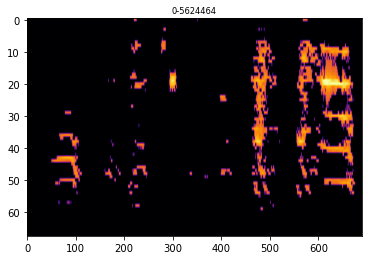

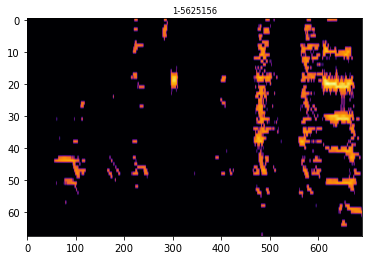

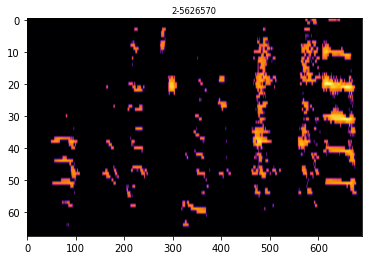

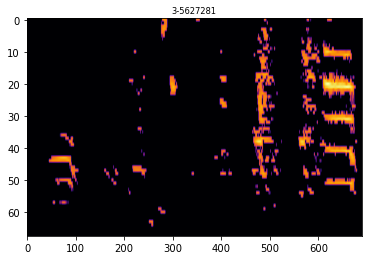

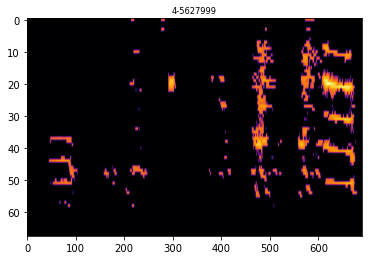

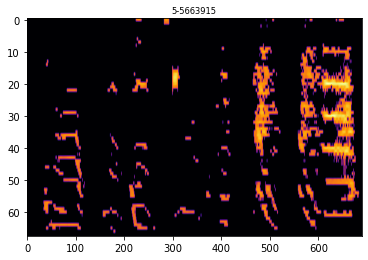

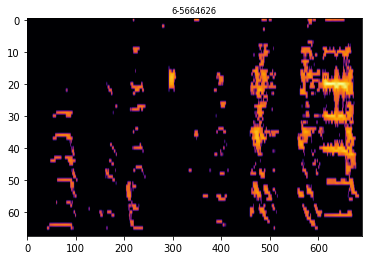

In [279]:
for i in curated_peaks:
    peak = p[0][i]
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))

In [280]:
# make a mot_arr similar to the bout_arr with start:end
hand_mot_arr_s = np.array([[p[0][i], p[0][i] + s_temp.shape[1]] for i in curated_peaks])*0.001
#hand_mot_arr = (hand_mot_arr_ms * mic_s_f * 0.001).astype(np.int64)
hand_mot_arr_s.shape

(7, 2)

### save the mot array

In [281]:
mot_arr_name = 'mot_wav_mic.npy'

mot_arr_path = os.path.join(exp_struct['folders']['derived'], mot_arr_name)

np.save(mot_arr_path, hand_mot_arr_s)
np.savetxt(mot_arr_path + '.txt', hand_mot_arr_s)

In [282]:
mot_arr_path

'/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-07-01/sglx/1229_g0/mot_wav_mic.npy'

In [283]:
hand_mot_arr_s.shape

(7, 2)

In [133]:
np.load('/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-29/sglx/1842_g0/mot_wav_mic.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-29/sglx/1842_g0/mot_wav_mic.npy'